In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pywt
from astropy.io import fits
from astropy import wcs
from astropy import units as u
from astropy.coordinates import SkyCoord


In [2]:
#hdul = fits.open('fits\k4n_170113_084822_ori.fits.fz')
hdul = fits.open('./../fits\k4n_140319_110826_dover.fits.fz')
#hdul = fits.open('fits\S20230309S0221.fits')
#w = wcs.WCS(hdul[1].header)

fits_image = hdul[2].data
plt.imshow(fits_image)
plt.gca().invert_yaxis()

coord_str="05 35 10.07 -05 02 39.20"
c=SkyCoord(coord_str,unit=(u.deg, u.deg))

hdr = hdul[1].header

#w = WCS(hdul[0].header)
#x, y = w.world_to_pixel(c)

FileNotFoundError: [Errno 2] No such file or directory: './../fits\\k4n_140319_110826_dover.fits.fz'

In [ ]:
print(pywt.wavelist(kind='continuous'))

print(pywt.wavelist(kind='discrete'))


['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym

mean: 1.2614095934961351
std: 0.02010996705378024


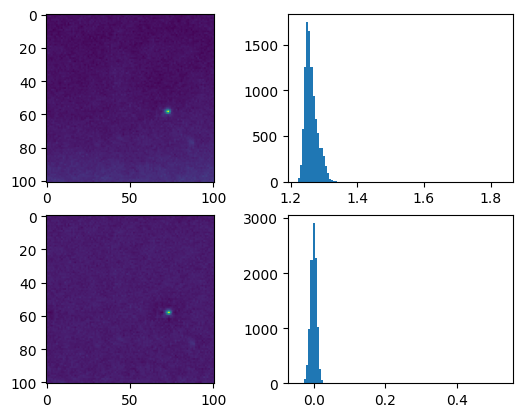

In [ ]:
def crop_fits(fits,center_x_y,window_size):

    if np.size(window_size)==1:
        start_x = center_x_y[0]-window_size//2
        stop_x = center_x_y[0]+window_size//2+1
        start_y = center_x_y[1]-window_size//2
        stop_y = center_x_y[1]+window_size//2+1
    else:
        start_x = center_x_y[0]-window_size[0]//2
        stop_x = center_x_y[0]+window_size[0]//2+1
        start_y = center_x_y[1]-window_size[1]//2
        stop_y = center_x_y[1]+window_size[1]//2+1



    fits_section = fits[start_y:stop_y,start_x:stop_x]

    x_extents = np.arange(start_x,stop_x)
    y_extents = np.arange(start_y,stop_y)

    return fits_section, x_extents, y_extents

def swt_enhance(image: np.array, wavelet:list = 'exhaustive', max_level: int = 3, approx_level=-1):

    if wavelet == 'exhaustive':
        wavelet = pywt.wavelist(kind='discrete')
    elif not isinstance(wavelet,list):
        wavelet = list([wavelet])
    
    wavelet = [wave for wave in wavelet if pywt.Wavelet(wave).orthogonal]

    if len(wavelet)==0:
        print('No orthogonal wavelets provided. Defaulting to db2')
        wavelet=['db2']

    orig_size = np.shape(image)

    orig_row_slice = slice(0,orig_size[0])
    orig_col_slice = slice(0,orig_size[1])

    buffered_size = np.int32(2**(np.floor(np.log2(orig_size))+1))

    buffer_addn = buffered_size - np.shape(image)

    buffered_image = np.pad(image,
                            pad_width=((0,buffer_addn[0]),(0,buffer_addn[1])),
                            mode='reflect')
    
    if approx_level==-1:
        level_list = pd.Index(np.arange(0,max_level+1), name='Levels')
    else:
        level_list = pd.Index([approx_level], name='Levels')
        
    results = pd.DataFrame(columns=wavelet, index=level_list)
    
    for wave in wavelet:

        for lvl in level_list:

            scA_lvl = pywt.swt2(buffered_image,
                                wavelet=wave,
                                level=max_level,
                                start_level=lvl,
                                trim_approx=True,
                                norm=True)

            threshold_value = np.mean(scA_lvl[0][orig_row_slice, orig_col_slice]) - \
                                3*np.std(scA_lvl[0][orig_row_slice, orig_col_slice])

            swt_low_pass = pywt.threshold(scA_lvl[0],
                                             value= threshold_value,
                                             mode='hard',
                                             substitute=0)

            swt_approx = pywt.iswt2((swt_low_pass,
                                        (scA_lvl[0]*0,scA_lvl[0]*0,scA_lvl[0]*0)),
                                    wavelet=wave,
                                    norm=True)[orig_row_slice, orig_col_slice]

            swt_output = (buffered_image[orig_row_slice, orig_col_slice]-swt_approx)
            
            effective_contrast = (np.max(swt_output)-np.mean(swt_output))/np.std(swt_output)

            results.loc[lvl, wave] = effective_contrast

    return swt_output, results

def swt_coarse_find(image: np.array, wavelet='coif1', max_level=3, level=1):

    swt_passed, _ = swt_enhance(image, wavelet=wavelet, max_level=max_level, approx_level=level)

    max_image_row, max_image_col = np.unravel_index(np.argmax(swt_passed),swt_passed.shape)

    return max_image_row, max_image_col, swt_passed

pick_point = [845,880]
study_level = 2
fits_cropped, x_vals, y_vals = crop_fits(fits_image,pick_point,101)

cropped_mean = np.mean(fits_cropped,axis=None)
cropped_std = np.std(fits_cropped,axis=None)

print('mean: '+str(cropped_mean))
print('std: '+str(cropped_std))

swtA, swtResults = swt_enhance(fits_cropped, wavelet='coif1', max_level=study_level)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(fits_cropped)

plt.subplot(2,2,2)
plt.hist(np.ravel(fits_cropped),bins=100)

plt.subplot(2,2,3)
plt.imshow(swtA)

plt.subplot(2,2,4)
plt.hist(np.ravel(swtA),bins=100)
plt.show()






47.07876559638431
1
coif1


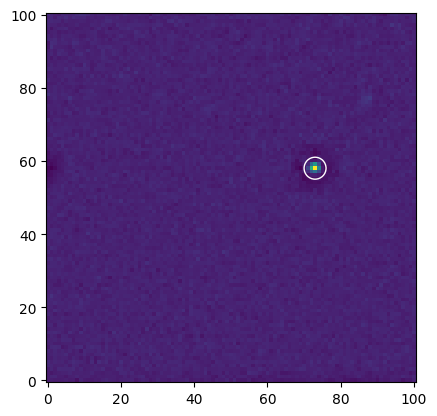

In [ ]:
print(np.max(swtResults))
max_result_row, max_result_col = np.unravel_index(np.argmax(swtResults),swtResults.shape)
print(swtResults.index[max_result_row])
print(swtResults.columns[max_result_col])

max_image_row, max_image_col, best_swt_image = swt_coarse_find(fits_cropped,
                                                                wavelet=swtResults.columns[max_result_col],
                                                                max_level=study_level,
                                                                level=swtResults.index[max_result_row])

plt.imshow(best_swt_image,origin='upper')
plt.gca().invert_yaxis()
plt.scatter(max_image_col,max_image_row,s=250, edgecolor='white', facecolor='none', linewidths=1)
plt.show()



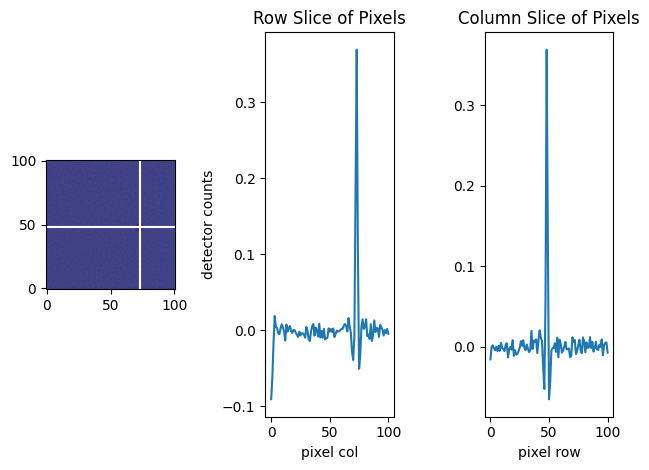

In [ ]:


row_idx, col_idx = np.unravel_index(np.argmax(best_swt_image,axis=None),np.shape(best_swt_image))

plt.subplot(1,3,1)
row_size,col_size = best_swt_image.shape
row_pts = np.arange(0,col_size)
col_pts = np.arange(0,row_size)

row_vals = best_swt_image[row_idx,:]
col_vals = best_swt_image[:,col_idx]
plt.plot(row_pts, row_idx*np.ones([col_size,1]),col_idx*np.ones([row_size,1]),col_pts,color='white')
plt.imshow(best_swt_image)

plt.gca().invert_yaxis()

plt.subplot(1,3,2)
plt.plot(row_vals)
plt.xlabel('pixel col')
plt.ylabel('detector counts')
plt.title('Row Slice of Pixels')

plt.subplot(1,3,3)
plt.plot(col_vals)
plt.xlabel('pixel row')
plt.title('Column Slice of Pixels')
plt.gcf().tight_layout()
plt.show()

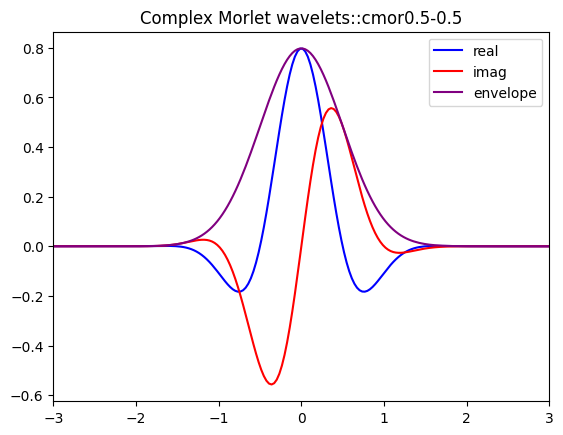

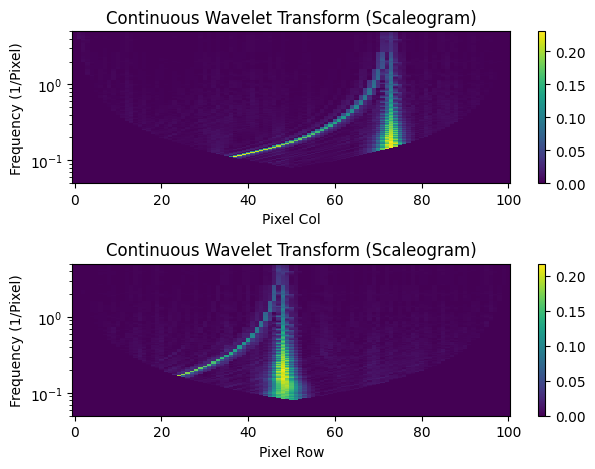

In [19]:
wavelet = "cmor0.5-0.5"
waveletName = pywt.ContinuousWavelet(wavelet).name
waveletFam = pywt.ContinuousWavelet(wavelet).family_name
[psi,x_wvlt] = pywt.ContinuousWavelet(wavelet).wavefun(level=9.81)

                                   
plt.plot(x_wvlt,np.real(psi),color='blue',label='real')
plt.plot(x_wvlt,np.imag(psi),color='red',label='imag')
plt.plot(x_wvlt,np.abs(psi),color='purple',label='envelope')
plt.gca().set_title(waveletFam+'::'+waveletName)
plt.gca().legend(loc='upper right')
plt.xlim([-3,3])
widths = np.geomspace(0.1, 10, num=1000)

pad_extent = int(np.power(2,np.ceil(np.log2(len(row_vals))))-len(row_vals))
pad_extent_before = pad_extent//2
pad_extent_after = pad_extent-pad_extent_before
padded_row_vals = np.pad(row_vals,[pad_extent_before,pad_extent_after],'constant',constant_values=np.nan)
cwtmatr_horz, freqs_horz = pywt.cwt(padded_row_vals, widths, wavelet)
cwtmatr_horz = np.abs(cwtmatr_horz[:,pad_extent_before:-pad_extent_after])
cwtmatr_horz = np.nan_to_num(cwtmatr_horz, nan=0)

# plot result using matplotlib's pcolormesh (image with annoted axes)
plt.figure()
plt.subplot(2,1,1)
pcm_horz = plt.pcolormesh(col_pts, freqs_horz, cwtmatr_horz)
plt.gca().set_yscale("log")
plt.gca().set_xlabel("Pixel Col")
plt.gca().set_ylabel("Frequency (1/Pixel)")
plt.gca().set_title("Continuous Wavelet Transform (Scaleogram)")
plt.gcf().colorbar(pcm_horz)

padded_col_vals = np.pad(col_vals,[1,1],'constant',constant_values=[np.nan,np.nan])
cwtmatr_vert, freqs_vert = pywt.cwt(padded_col_vals, widths, wavelet)
cwtmatr_vert = np.abs(cwtmatr_vert[:,1:-1])
cwtmatr_vert = np.nan_to_num(cwtmatr_vert, nan=0)

# plot result using matplotlib's pcolormesh (image with annoted axes)
plt.subplot(2,1,2)
pcm_vert = plt.pcolormesh(row_pts, freqs_vert, cwtmatr_vert)
plt.gca().set_yscale("log")
plt.gca().set_xlabel("Pixel Row")
plt.gca().set_ylabel("Frequency (1/Pixel)")
plt.gca().set_title("Continuous Wavelet Transform (Scaleogram)")
plt.gcf().colorbar(pcm_vert)
plt.gcf().tight_layout()

Max Response Freq (Horiz): 0.14636474175214081
Max Location (Horiz): 48


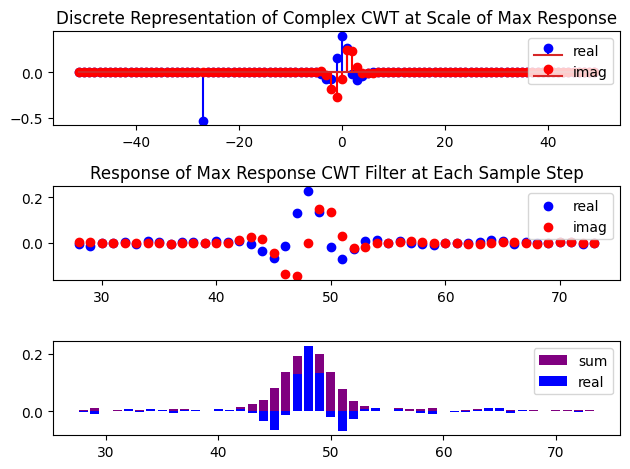

In [9]:
max_freq_horz_idx, max_pix_idx_horz = np.unravel_index(np.argmax(cwtmatr_horz, axis=None), cwtmatr_horz.shape)

max_freq_horz = freqs_horz[max_freq_horz_idx]

if np.size(widths)==1:
    max_freq_horz_idx=None
    
cwt_horz_max, cwt_freq_max_h = pywt.cwt( padded_row_vals, widths[max_freq_horz_idx], wavelet)
cwt_horz_max = cwt_horz_max[:,pad_extent_before:(pad_extent_before+len(row_vals))]

scale = widths[max_freq_horz_idx]

plt.figure()
plt.subplot(3,1,1)
unit_impulse_horz = np.zeros(row_vals.size)
horz_length = len(row_vals)
unit_impulse_horz[horz_length//2+1] = 1

uir_horz = pywt.cwt(unit_impulse_horz,widths[max_freq_horz_idx],wavelet)
cwt_uir_horz_real = np.real(uir_horz[0][0])
cwt_uir_horz_imag = np.imag(uir_horz[0][0])
plt.stem(np.arange(-horz_length//2,horz_length//2), cwt_uir_horz_real,linefmt='blue',label="real")
plt.stem(np.arange(-horz_length//2,horz_length//2), cwt_uir_horz_imag,linefmt='red',label="imag")
plt.legend(loc='upper right')
plt.title("Discrete Representation of Complex CWT at Scale of Max Response")

plt.subplot(3,1,2)
cwt_horz_max_real = np.real(cwt_horz_max[0])
cwt_horz_max_imag = np.imag(cwt_horz_max[0])
cwt_horz_max_sum = np.abs(cwt_horz_max[0])
plt.scatter(col_pts, cwt_horz_max_real,color='blue',label='real')
plt.scatter(col_pts, cwt_horz_max_imag,color='red',label='imag')
plt.legend(loc='upper right')
plt.title("Response of Max Response CWT Filter at Each Sample Step")

plt.subplot(3,1,3)
phase_angle_max_horz = np.arctan2(cwt_horz_max_imag[max_pix_idx_horz],cwt_horz_max_real[max_pix_idx_horz])

plt.bar(col_pts, cwt_horz_max_sum,color='purple',label='sum')
plt.bar(col_pts, cwt_horz_max_real,color='blue',label='real')
#plt.xlim([max_pix_idx_horz-1.5,max_pix_idx_horz+1.5])
#plt.ylim([3200,3500])
plt.legend(loc='upper right')

plt.gcf().tight_layout()

print("Max Response Freq (Horiz): "+str(max_freq_horz))
print("Max Location (Horiz): "+str(max_pix_idx_horz))



In [10]:
max_freq_vert_idx, max_pix_idx_vert = np.unravel_index(np.argmax(cwtmatr_vert, axis=None), cwtmatr_vert.shape)
max_freq_vert = freqs_vert[max_freq_vert_idx]
print(col_pts[max_pix_idx_vert])

cwt_vert_max, *_ = pywt.cwt( padded_col_vals, widths[max_freq_vert_idx], wavelet)
cwt_vert_max = cwt_vert_max[:,1:-1]

cwt_vert_max_real = np.real(cwt_vert_max[0])
cwt_vert_max_imag = np.imag(cwt_vert_max[0])
cwt_vert_max_sum = np.abs(cwt_vert_max[0])

phase_angle_max_vert = np.arctan2(cwt_vert_max_imag[max_pix_idx_vert],cwt_vert_max_real[max_pix_idx_vert])
print(phase_angle_max_vert)

48
-0.08977648379592702


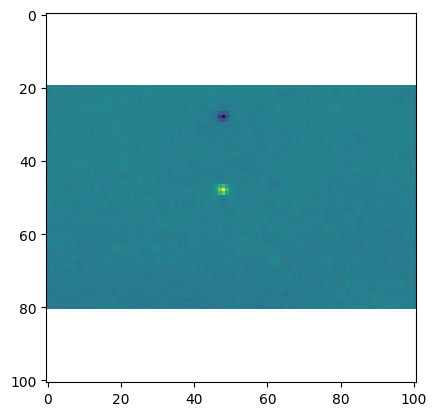

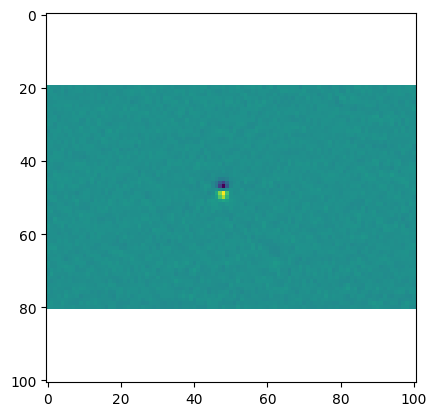

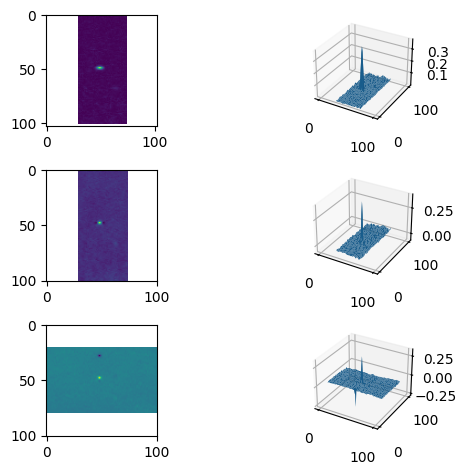

In [12]:
padded_fits_cropped = np.pad(fits_cropped,pad_width=(1, 1),mode='constant',constant_values=(np.nan,np.nan))

cwt_hmax, horz_max_freqs = pywt.cwt( padded_fits_cropped, widths[max_freq_horz_idx], wavelet,axis=1)
cwt_hmax_valid = cwt_hmax[0][1:-1,1:-1]

h_phased_crop = np.cos(phase_angle_max_horz)*np.real(cwt_hmax_valid)+np.sin(phase_angle_max_horz)*np.imag(cwt_hmax_valid)

cwt_vmax, vert_max_freqs = pywt.cwt( padded_fits_cropped, widths[max_freq_vert_idx], wavelet,axis=0)
cwt_vmax_valid = cwt_vmax[0][1:-1,1:-1]

v_phased_crop = np.cos(phase_angle_max_vert)*np.real(cwt_vmax_valid)+np.sin(phase_angle_max_vert)*np.imag(cwt_vmax_valid)

fig = plt.figure()
ax = fig.add_subplot(3,2,1)
plt.imshow(abs(cwt_hmax[0]))

ax = fig.add_subplot(3,2,2,projection='3d')
y,x = np.shape(abs(fits_cropped))
X, Y = np.meshgrid(np.arange(0,y), np.arange(0,x))
ax.plot_surface(X,Y,abs(cwt_hmax_valid))

ax = fig.add_subplot(3,2,3)
plt.imshow(h_phased_crop)

ax = fig.add_subplot(3,2,4,projection='3d')
ax.plot_surface(X,Y,h_phased_crop)

ax = fig.add_subplot(3,2,5)
plt.imshow(v_phased_crop)

ax = fig.add_subplot(3,2,6,projection='3d')
ax.plot_surface(X,Y,v_phased_crop)

plt.gcf().tight_layout()

-0.04862058611329196


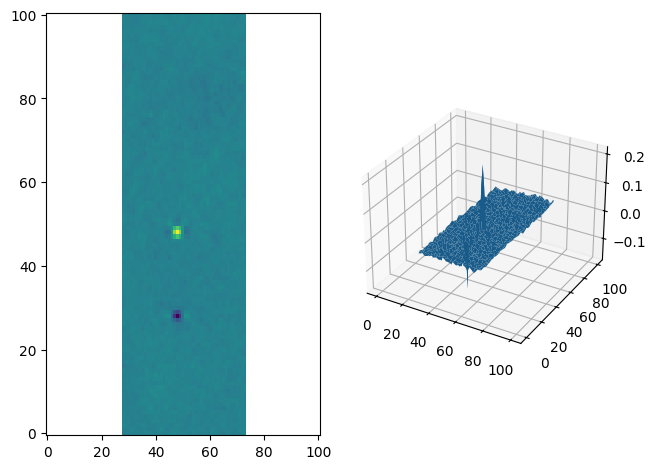

In [16]:
h_pad = int(np.ceil(np.max(pywt.ContinuousWavelet(wavelet).wavefun(widths[max_freq_horz_idx])[1])))

v_pad = int(np.ceil(np.max(pywt.ContinuousWavelet(wavelet).wavefun(widths[max_freq_vert_idx])[1])))

padded_hp_vcwt = pywt.pad(h_phased_crop,pad_widths=((0,v_pad),(0,h_pad)),mode='reflect')


h_phased_vcwt_padded = pywt.cwt(padded_hp_vcwt, widths[max_freq_vert_idx],wavelet,axis=0)
h_phased_vcwt = h_phased_vcwt_padded[0][0][0:np.shape(h_phased_crop)[0],0:np.shape(h_phased_crop)[1]]

cwt_hp_vert_max_real = np.real(h_phased_vcwt[:,max_pix_idx_horz])
cwt_hp_vert_max_imag = np.imag(h_phased_vcwt[:,max_pix_idx_horz])
cwt_hp_vert_max_sum = np.abs(h_phased_vcwt[:,max_pix_idx_horz])

phase_angle_max_hp_vert = np.arcsin(cwt_hp_vert_max_imag[max_pix_idx_vert]/cwt_hp_vert_max_sum[max_pix_idx_vert])
print(phase_angle_max_hp_vert)

hv_phased_cwt2 = np.cos(phase_angle_max_hp_vert)*np.real(h_phased_vcwt)+np.sin(phase_angle_max_hp_vert)*np.imag(h_phased_vcwt)

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.pcolormesh(X,Y,hv_phased_cwt2)

ax = fig.add_subplot(1,2,2,projection='3d')
ax.plot_surface(X,Y,hv_phased_cwt2)

plt.gcf().tight_layout()

In [17]:
def make_shifted_bump(wavelet,scale,shift):

    [psi,x] = pywt.ContinuousWavelet(wavelet).wavefun(level=scale)

    sum_psi = np.abs(psi)

    query_pts = np.arange(2*min(x),2*max(x)+1)

    shifted_bump = np.interp(query_pts-shift,x,sum_psi)

    return shifted_bump, query_pts

def wavelet_phase_correct_linear(wavelet,scale,center,width):
    
    inc = width/2
    
    shift_vals = np.arange(center-inc,center+2*inc,inc)

    phase_angles = np.empty([len(shift_vals),])

    for i in np.arange(0,len(shift_vals)):
            
        shifted, *_ = make_shifted_bump(wavelet, scale, shift_vals[i])

        coeffs_shifted = pywt.cwt(shifted, scale,wavelet,axis=0)
        
        coeffs_shifted_phases = np.arctan2(np.imag(coeffs_shifted[0][0]),np.real(coeffs_shifted[0][0]))
        
        phase_angles[i] = coeffs_shifted_phases[len(coeffs_shifted_phases)//2]

    (slope, offset), (SSE,), *_ = np.polyfit(phase_angles, shift_vals, deg=1, full=True)

    return slope, offset, SSE

def wavelet_phase_correct_interp(wavelet,scale,phase, resolution):
    
    inc = resolution

    shift_vals = np.arange(-0.5,0.5+inc,inc)

    phase_angles = np.empty([len(shift_vals),])

    for i in np.arange(0,len(shift_vals)):
            
        shifted, *_ = make_shifted_bump(wavelet, scale, shift_vals[i])

        coeffs_shifted = pywt.cwt(shifted, scale,wavelet,axis=0)
        
        coeffs_shifted_phases = np.arctan2(np.imag(coeffs_shifted[0][0]),np.real(coeffs_shifted[0][0]))
        
        phase_angles[i] = coeffs_shifted_phases[len(coeffs_shifted_phases)//2]

    phase_and_shift = np.stack([phase_angles,shift_vals])

    phase_and_shift = phase_and_shift[:,phase_and_shift[0,:].argsort()]      

    pixel_shift = np.interp(phase,phase_and_shift[0,:],phase_and_shift[1,:])

    return pixel_shift


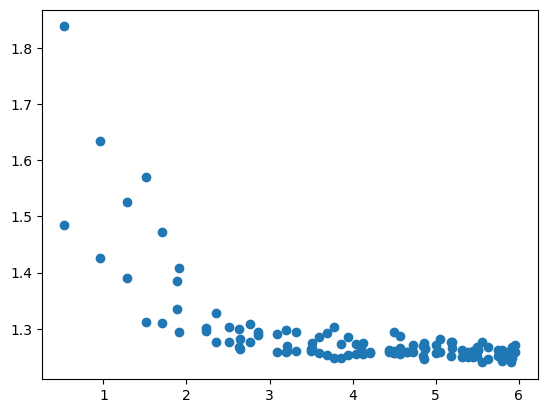

In [18]:
x_shift = wavelet_phase_correct_interp(wavelet, widths[max_freq_horz_idx], phase_angle_max_horz, 0.01)
y_shift = wavelet_phase_correct_interp(wavelet, widths[max_freq_vert_idx], phase_angle_max_hp_vert, 0.01)

dist_matrx = np.sqrt((X-(max_pix_idx_horz+x_shift))**2 + (Y-(max_pix_idx_vert+y_shift))**2)
dist_array = np.reshape(dist_matrx,np.size(dist_matrx))
fits_cropped_array = np.reshape(fits_cropped,np.size(fits_cropped))

fig = plt.figure()
plt.scatter(dist_array[dist_array<6],fits_cropped_array[dist_array<6])



In [19]:
#from astropy.io import fits
#from astropy.wcs import WCS

#fn = get_pkg_data_filename('data/j94f05bgq_flt.fits', package='astropy.wcs.tests')
#f = fits.open(fn)

w = wcs.WCS(hdul[1].header)

# ---- Verify pixels are x and y (not row, column)
sky = w.pixel_to_world(y_vals[max_pix_idx_vert]+y_shift, x_vals[max_pix_idx_horz]+x_shift)
print(sky)  


#hdul.close()

ValueError: ERROR 5 in wcsset() at line 2775 of file cextern\wcslib\C\wcs.c:
Invalid parameter value.
ERROR 4 in linset() at line 737 of file cextern\wcslib\C\lin.c:
Failed to initialize distortion functions.
ERROR 3 in watset() at line 2889 of file cextern\wcslib\C\dis.c:
Unrecognized field name for WAT (TNX) on axis 1: DQ1.DOCORR.
